In [1]:
# standard libraries
import numpy as np #numpy warnings may be safely ignored, known issue.
import pandas as pd
from collections import defaultdict
from math import * # Used for the haversine/distance calculations
import datetime as dt 

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# for model building
from sklearn.cluster import KMeans

# for optimizations
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# Make an empty DefaultDict
# fill dictionary {year: station data}
# build hierarchal dataframe using dictionary

# Example of data location
# https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2010/NiceRide_station_2010.csv

nr_dict = defaultdict()
for x in [2010 + x for x in range(8)] :
    nr_dict[x] = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/" \
                             +str(x)+"/NiceRide_station_"+str(x)+".csv")
nr_station = pd.concat(nr_dict)

In [3]:
# Extracting the most robust year/data set from the total
nr_station_2017 = nr_station.loc[(2017),:]

In [4]:
nr_station_2017.tail()

,Terminal,Station,Latitude,Longitude,Ndocks
196,30199,Hidden Falls Park,44.907001,-93.191432,19
197,30201,Elwood Ave N & Oak Park Ave N,44.987160,-93.301944,15
198,30202,Mill City Quarter,44.980500,-93.261800,23
199,30203,W 50th Street & W Minnehaha Pkwy,44.912125,-93.298552,23
200,30204,NE Central Ave & NE 14th Ave,45.002526,-93.247162,15


## First load in matrix that has the arc distance of each station comparatively.

In [5]:
distance = pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2017/"\
                        "distance_matrix_2017.csv",index_col=0)

In [6]:
distance.info()
distance.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 30000 to 30204
Columns: 201 entries, 30000 to 30204
dtypes: float64(201)
memory usage: 317.2 KB


,30000,30001,30002,30003,30004,30005,30006,30007,30008,30009,...,30194,30195,30196,30197,30198,30199,30201,30202,30203,30204
30000,0.000000,2.500883,1.466835,2.471107,1.267481,0.304709,1.308283,1.034074,2.514716,0.970652,...,1.792963,1.091036,1.346930,1.120933,0.944879,6.253741,2.223943,0.397380,5.431379,1.301979
30001,2.500883,0.000000,1.062434,4.686271,2.976568,2.642299,2.790346,2.456370,1.899581,1.775162,...,1.178669,1.412001,1.362179,1.653395,1.579928,3.813231,4.358510,2.467683,4.825362,3.331634
30002,1.466835,1.062434,0.000000,3.641812,1.967888,1.648298,1.808542,1.448112,1.612348,0.969751,...,0.977645,0.389264,0.738530,0.920689,0.633325,4.788731,3.322895,1.405513,4.753667,2.470703
30003,2.471107,4.686271,3.641812,0.000000,1.746448,2.564107,1.971116,2.246913,3.718459,3.438583,...,4.236012,3.364533,3.782869,3.585482,3.330279,8.096739,0.361928,2.300340,5.491521,2.988440
30004,1.267481,2.976568,1.967888,1.746448,0.000000,1.530430,0.242315,0.521591,2.057588,2.053101,...,2.722854,1.761634,2.284861,2.171021,1.813986,6.364891,1.399569,0.899256,4.474715,2.429523


In [7]:
# If we wanted to merge our two new dataframes together
# nr_station_2017 = pd.merge(nr_station_2017, distance, left_on='Terminal', right_index=True)

In [8]:
distance_matrix = distance.values

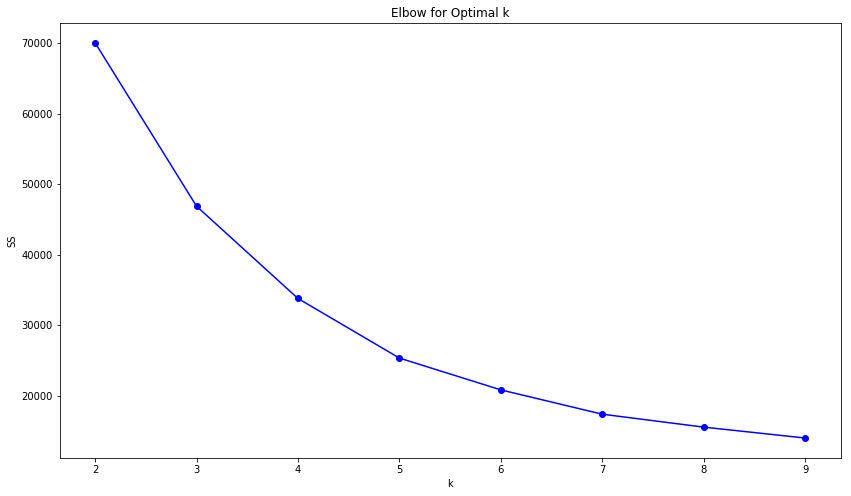

In [9]:
SS = []

# k means determine k
for k in range(2,10) :
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)

    SS.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(14,8))
plt.plot(range(2,10), SS, 'bo-')
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Elbow for Optimal k')
plt.show()

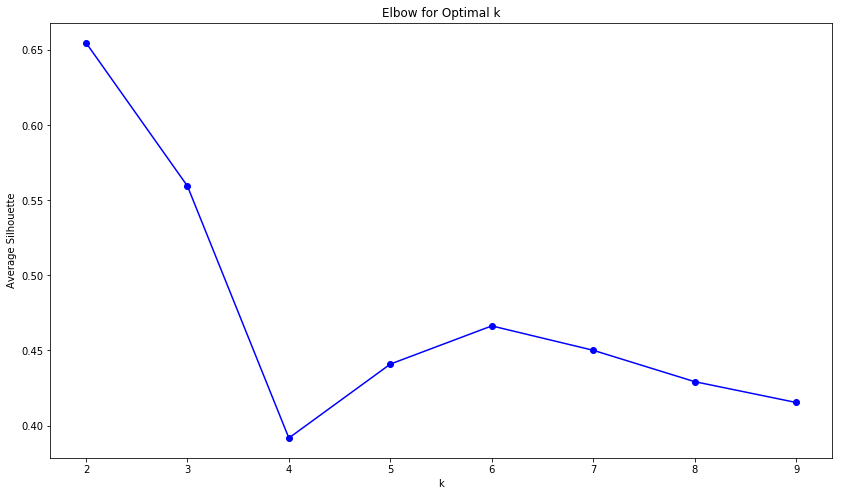

In [10]:
avg_sil = []

#    Compute clustering algorithm (e.g., k-means clustering) for different values of k. For instance, by varying k from 1 to 10 clusters.
for k in range(2,10) :
    clusterer = KMeans(n_clusters=k, random_state=24).fit(distance_matrix)
    cluster_labels = clusterer.labels_
    
#    For each k, calculate the average silhouette of observations (avg.sil).
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels)
    avg_sil.append(silhouette_avg)
    

#    Plot the curve of avg.sil according to the number of clusters k.
plt.figure(figsize=(14,8))
plt.plot(range(2,10), avg_sil, 'bo-')
plt.xlabel('k')
plt.ylabel('Average Silhouette')
plt.title('Elbow for Optimal k')
plt.show()

    
#    The location of the maximum (local) is considered as the appropriate number of clusters.
k_value = avg_sil.index(max(avg_sil[2:10])) + 2

In [11]:
k_value

6

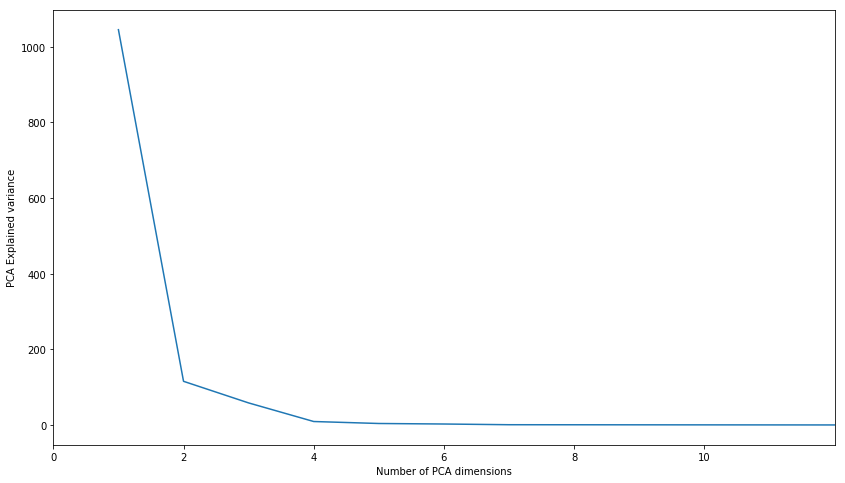

In [12]:
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(distance_matrix)

plt.figure(figsize=[14,8])
plt.xlim(0,12)
plt.plot(range(1,len(pca.explained_variance_)+1), pca.explained_variance_)
plt.xticks(range(0,12,2))
plt.ylabel('PCA Explained variance')
plt.xlabel('Number of PCA dimensions')
plt.show()

In [13]:
pca_df = pd.DataFrame(PCA(n_components=2).fit_transform(distance_matrix), columns=['x','y'], index=nr_station_2017.index)
pca_df = pd.DataFrame(nr_station_2017.Terminal).join(pca_df)
    # Joins customer names to pca_df containing x-y PCA components
print(pca_df.head())

   Terminal          x          y
0     30000 -23.230553  -5.348980
1     30001  -4.544014 -14.150485
2     30002 -15.734367 -12.502557
3     30003 -21.637575  19.810301
4     30004 -26.821350   3.160106


Optimize to calculate greatest slope change and use that to dynamically decide n_components

In [14]:
def kmeans_plot(pca_df, distance_matrix, x=4) :
    pca_df['cluster']= KMeans(n_clusters=x).fit(distance_matrix).labels_
    sns.lmplot(x='x', y='y', hue='cluster', data=pca_df, fit_reg=False, size=5)

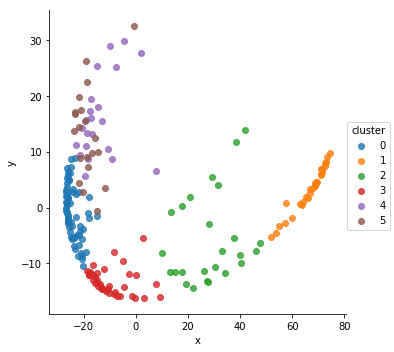

In [15]:
kmeans_plot(pca_df, distance_matrix, k_value)

In [16]:
pca_df['cluster']= KMeans(n_clusters=k_value).fit(distance_matrix).labels_
six_nr_clusters = pd.merge(nr_station_2017, pca_df, left_on='Terminal', right_on='Terminal')

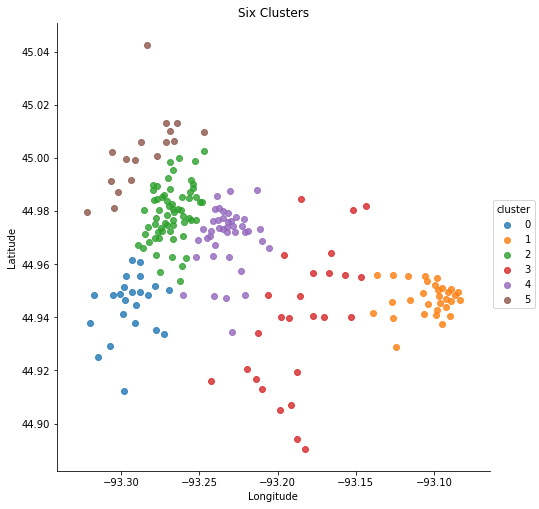

In [17]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)
ax = plt.gca()
ax.set_title('Six Clusters')

In [18]:
#print(centers[:,0])
#print(centers[:,1])

#six_clusters = KMeans(n_clusters=6).fit(distance_matrix)
#centers = np.array(six_clusters.cluster_centers_)
#plt.scatter(centers[:,0], centers[:,1], marker="*", color='r')

# uilding the models
pca_model = PCA(n_components=2).fit_transform(distance_matrix)
six_kmeans = KMeans(n_clusters=6).fit(pca_model)

pca_df['cluster']= six_kmeans.labels_
centers = six_kmeans.cluster_centers_


In [19]:
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,2
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,4
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,4
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,5
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,2


In [20]:
# Read in the ridership database for year (2017) and build as pandas dataframe
rides_df = pd.DataFrame(pd.read_csv("https://raw.githubusercontent.com/SethDKelly/NiceRideMN/master/Nice_Ride_data/2017/NiceRide_trip_history_2017.csv"))

In [21]:
rides_df.info()
rides_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459903 entries, 0 to 459902
Data columns (total 8 columns):
Start_date    459903 non-null object
Start_name    459903 non-null object
Start_id      459903 non-null int64
End_date      459903 non-null object
End_name      459903 non-null object
End_id        459903 non-null int64
duration      459903 non-null int64
account       459903 non-null object
dtypes: int64(3), object(5)
memory usage: 28.1+ MB


,Start_date,Start_name,Start_id,End_date,End_name,End_id,duration,account
0,2017-11-05 21:45:00,Hennepin Ave & S Washington Ave,30184,2017-11-05 22:02:00,Logan Park,30104,1048,Member
1,2017-11-05 21:45:00,Broadway Street N & 4th Street E,30122,2017-11-05 22:26:00,Broadway Street N & 4th Street E,30122,2513,Member
2,2017-11-05 21:43:00,Dale Street & Grand Ave.,30106,2017-11-05 22:13:00,N Milton Street & Summit Ave,30101,1817,Member
3,2017-11-05 21:41:00,Weisman Art Museum,30183,2017-11-05 22:05:00,22nd Ave S & Franklin Ave,30014,1399,Casual
4,2017-11-05 21:38:00,South 2nd Street & 3rd Ave S,30030,2017-11-05 21:44:00,6th Ave SE & University Ave,30088,370,Member


## Data prep/cleaning

In [22]:
# Adjusting the start and end date columns to datetime

rides_df['Start_date'] = rides_df['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
rides_df['End_date'] = rides_df['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

## splitting based on (non-)member

In [23]:
member = rides_df[rides_df['account'] == "Member"]
casual = rides_df[rides_df['account'] != "Member"]

In [24]:
station_member = member[['Start_id', 'duration']]
station_member = station_member.groupby(['Start_id']).count()
station_member = station_member.rename(columns={'duration':'m_count'})

In [25]:
casual_member = casual[['Start_id', 'duration']]
casual_member = casual_member.groupby(['Start_id']).count()
casual_member = casual_member.rename(columns={'duration':'c_count'})

## Merging the data to our clustered dataframe

In [26]:
six_nr_clusters = pd.merge(six_nr_clusters, station_member, left_on='Terminal', right_index=True)
six_nr_clusters = pd.merge(six_nr_clusters, casual_member, left_on='Terminal', right_index=True)

In [27]:
temp = defaultdict()
for x in np.unique(six_nr_clusters.cluster.values) :
    temp['cluster_'+str(x)] = six_nr_clusters.groupby(six_nr_clusters.cluster==x)[['m_count', 'c_count']].describe()
cluster_describe = pd.concat(temp)
cluster_describe

m_count                                                    \
                    count         mean          std    min      25%     50%   
          cluster                                                             
cluster_0 False     178.0  1485.786517  1671.634671   61.0   348.50   855.0   
          True       23.0  1088.869565   582.121848  239.0   620.50  1033.0   
cluster_1 False     170.0  1632.582353  1655.234018   61.0   465.75  1139.5   
          True       31.0   386.290323   224.764646  106.0   203.50   384.0   
cluster_2 False     138.0  1217.065217  1665.796389   94.0   280.00   510.5   
          True       63.0  1929.507937  1289.869584   61.0  1040.50  1649.0   
cluster_3 False     175.0  1590.074286  1647.635498   61.0   437.00  1046.0   
          True       26.0   432.730769   321.685879   94.0   218.25   339.5   
cluster_4 False     160.0  1087.137500  1116.181059   61.0   315.25   722.0   
          True       41.0  2818.829268  2287.490130  460.0   960.00  1942.0   
cluster_5 False     184.0  1551.092391  1616.890109   61.0   450.25  1009.0   
          True       17.0   241.941176   103.482771  104.0   160.00   240.0   

                                   c_count                                   \
                       75%     max   count         mean          std    min   
          cluster                                                             
cluster_0 False    1929.00  9294.0   178.0   759.629213   743.416915   31.0   
          True     1432.50  2231.0    23.0  1529.347826  1953.059107  178.0   
cluster_1 False    2092.00  9294.0   170.0   943.847059  1036.140375   36.0   
          True      449.50   985.0    31.0   320.483871   269.760866   31.0   
cluster_2 False    1412.25  9294.0   138.0   703.963768   992.034269   31.0   
          True     2557.00  6261.0    63.0  1162.571429   896.986401   83.0   
cluster_3 False    1956.50  9294.0   175.0   875.302857  1016.136256   31.0   
          True      500.75  1425.0    26.0   661.961538   724.333320   96.0   
cluster_4 False    1493.25  6261.0   160.0   868.787500  1072.655761   31.0   
          True     3404.00  9294.0    41.0   765.439024   512.714202  171.0   
cluster_5 False    1943.50  9294.0   184.0   907.315217  1007.313621   31.0   
          True      317.00   450.0    17.0   202.529412   156.289842   36.0   

                                                    
                      25%     50%      75%     max  
          cluster                                   
cluster_0 False    269.00   506.0  1047.25  5422.0  
          True     536.50   869.0  1137.50  8512.0  
cluster_1 False    310.75   691.5  1192.00  8512.0  
          True     143.50   263.0   367.50  1183.0  
cluster_2 False    221.00   405.0   875.00  8512.0  
          True     625.00  1007.0  1524.50  5422.0  
cluster_3 False    289.00   629.0  1102.00  8512.0  
          True     269.00   329.0   978.50  3185.0  
cluster_4 False    267.50   527.5  1085.75  8512.0  
          True     331.00   652.0   983.00  2071.0  
cluster_5 False    307.25   656.5  1165.75  8512.0  
          True      81.00   151.0   277.00   545.0

In [28]:
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster,m_count,c_count
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,2,2878,5422
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,4,960,618
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,4,1330,386
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,5,317,81
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,2,2574,1514


In [29]:
# This will find member mean rides per terminal per cluster
cluster_summary = pd.DataFrame(columns=['terminals', 'tot_rides', 'm_rides', 'c_rides', 'mem_term', \
                                        'cas_term', 'pct_mem_rides'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)])

for x in np.unique(six_nr_clusters.cluster.values) :
    #build arrays by cluster to work with
    member_array = six_nr_clusters[six_nr_clusters.cluster == x].m_count.values
    casual_array = six_nr_clusters[six_nr_clusters.cluster == x].c_count.values
    total_array = np.sum(member_array) + np.sum(casual_array)
    
    cluster_summary.loc['Cluster_'+str(x), 'terminals'] = len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'tot_rides'] = member_array.sum() + casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'm_rides'] = member_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'c_rides'] = casual_array.sum()
    cluster_summary.loc['Cluster_'+str(x), 'mem_term'] = member_array.sum()/len(member_array)
    cluster_summary.loc['Cluster_'+str(x), 'cas_term'] = casual_array.sum()/len(casual_array)
    cluster_summary.loc['Cluster_'+str(x), 'pct_mem_rides'] = (member_array.sum()/total_array.sum())*100

## Cluster summaries looking at:
 * Total rides:
     * Member
     * Casual
 * Total terminals:
     * Member mean rides per terminal
     * Casual mean rides per terminal
 * Percent member riders of each cluster

In [30]:
cluster_summary
# possible to add arc-distance (Lat-Long) square miles

,terminals,tot_rides,m_rides,c_rides,mem_term,cas_term,pct_mem_rides
Cluster_0,23,60219,25044,35175,1088.87,1529.35,41.5882
Cluster_1,31,21910,11975,9935,386.29,320.484,54.6554
Cluster_2,63,194801,121559,73242,1929.51,1162.57,62.4016
Cluster_3,26,28462,11251,17211,432.731,661.962,39.5299
Cluster_4,41,146955,115572,31383,2818.83,765.439,78.6445
Cluster_5,17,7556,4113,3443,241.941,202.529,54.4336


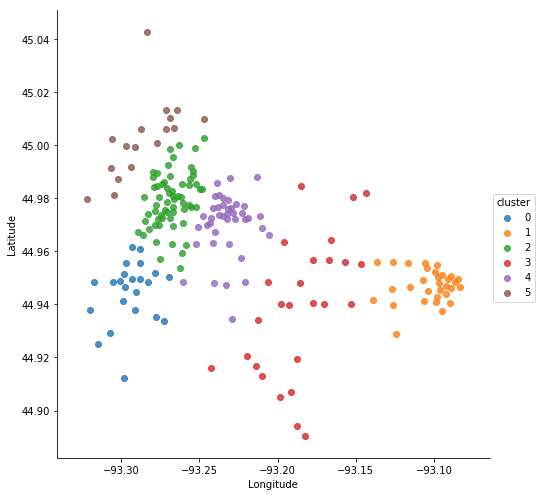

In [31]:
# Stations based on coordinates and clusters
sns.lmplot(x='Longitude', y='Latitude', hue='cluster', data=six_nr_clusters, fit_reg=False, size=7)

In [32]:
def haversine(lat1, lon1, lat2, lon2):
    '''
    Haversine definition: will calculate the distance between two points
    using the latitude and longitude of each point.
    '''
    miles_constant = 3959
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    mi = miles_constant * c
    return mi

In [35]:
def find_center(df, clus):
    
    max_l = df[df['cluster'] == clus]['Longitude'].max()
    min_l = df[df['cluster'] == clus]['Longitude'].min()
    center_long = (max_l - min_l)/2 + min_l
    
    max_w = df[df['cluster'] == clus]['Latitude'].max()
    min_w = df[df['cluster'] == clus]['Latitude'].min()
    center_lat = (max_w - min_w)/2 + min_w
    
    return (center_long, center_lat)

In [37]:
def circle_radius(df,clus):
    
    long1, lat1 = find_center(df,clus)
    
    lat2 = df[df['cluster'] == clus]['Latitude'].max()
    long2 = df[df['cluster'] == clus]['Longitude'].max()
    
    diff_long = long2-long1
    diff_lat = lat2-lat1
    if diff_lat > diff_long:
        return diff_lat
    else:
        return diff_long

In [38]:
max_w = six_nr_clusters[six_nr_clusters['cluster'] == 2]['Latitude'].max()
min_w = six_nr_clusters[six_nr_clusters['cluster'] == 2]['Latitude'].min()
max_l = six_nr_clusters[six_nr_clusters['cluster'] == 2]['Longitude'].max()
min_l = six_nr_clusters[six_nr_clusters['cluster'] == 2]['Longitude'].min()
print(max_w, min_w)
print(max_l, min_l)

45.002526 44.95355
-93.247162 -93.2890749


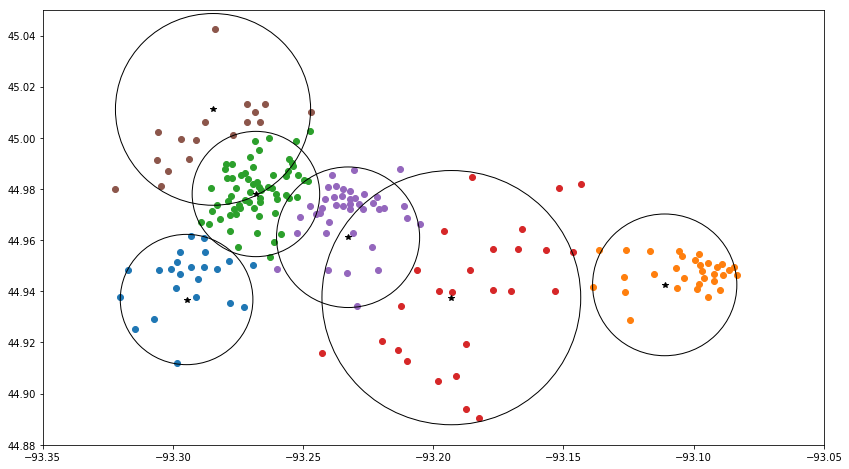

In [41]:
plt.figure(figsize=[14,8])
plt.xlim([-93.35,-93.05])
plt.ylim([44.88,45.05])

for x in range(6):
    long,lat = find_center(six_nr_clusters, x)
    radius = circle_radius(six_nr_clusters,x)
    circle = plt.Circle((long,lat), radius, fill=False)
    
    ax = plt.gca()
    ax.cla
    ax.scatter(x=six_nr_clusters[six_nr_clusters.cluster == x]['Longitude'].values,\
                    y=six_nr_clusters[six_nr_clusters.cluster == x]['Latitude'].values,\
                    marker='o')
    ax.plot(long,lat, marker='*', c='black')
    ax.add_artist(circle)
    
plt.show()

## Intra/Trans-cluster travel
 * This can be split be (non-)membership too

In [42]:
# Build a data frame with start terminal as indices, end terminal as columns filled with zeros
station_ids = nr_station_2017.Terminal.values
travel_df = pd.DataFrame(columns = station_ids, index = station_ids).fillna(0)

In [44]:
start = rides_df['Start_id'].values
end = rides_df['End_id'].values

for x in range(len(rides_df['Start_id'].values)) :
    travel_df.loc[start[x], end[x]] += 1

In [45]:
from sklearn.preprocessing import normalize

travel_matrix = travel_df.values
normed_travel = normalize(travel_matrix, axis=1, norm='l1')

In [46]:
clus_array = six_nr_clusters.cluster.values
term_cluster_pair = {}
for x in range(len(station_ids)) :
    term_cluster_pair[station_ids[x]] = clus_array[x]

In [47]:
'''
Build this better using lambda mapping and dictionaries
'''
travel_to = pd.DataFrame(columns=['to_0', 'to_1', 'to_2', 'to_3', 'to_4', 'to_5'], \
                              index=station_ids).fillna(0)

for x in station_ids :
    if term_cluster_pair[x] == 0:
        travel_to['to_0'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 1:
        travel_to['to_1'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 2:
        travel_to['to_2'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 3:
        travel_to['to_3'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 4:
        travel_to['to_4'] += (travel_df[x].values)
    elif term_cluster_pair[x] == 5:
        travel_to['to_5'] += (travel_df[x].values)

We're going to transpose the travel_matrix. This will give us instead of a data frame with start terminal as indices, end terminal as columns filled with zeros (from-to), a data frame with end terminals as indices and start terminals as columns (to-from).

The purpose of this is to show how the clusters interact with each other.

In [48]:
from_matrix = travel_matrix.transpose(1,0)

In [49]:
from_df = pd.DataFrame(from_matrix, columns=station_ids, index=station_ids)

In [50]:
'''
Build this better using lambda mapping and dictionaries
'''

travel_from = pd.DataFrame(columns=['from_0', 'from_1', 'from_2', 'from_3', 'from_4', 'from_5'], \
                              index=station_ids).fillna(0)

for x in station_ids :
    if term_cluster_pair[x] == 0:
        travel_from['from_0'] += (from_df[x].values)
    elif term_cluster_pair[x] == 1:
        travel_from['from_1'] += (from_df[x].values)
    elif term_cluster_pair[x] == 2:
        travel_from['from_2'] += (from_df[x].values)
    elif term_cluster_pair[x] == 3:
        travel_from['from_3'] += (from_df[x].values)
    elif term_cluster_pair[x] == 4:
        travel_from['from_4'] += (from_df[x].values)
    elif term_cluster_pair[x] == 5:
        travel_from['from_5'] += (from_df[x].values)

Build a super dataframe containing all the extra features we've created

In [51]:
six_nr_clusters = pd.merge(six_nr_clusters, travel_to, left_on='Terminal', right_index=True)
six_nr_clusters = pd.merge(six_nr_clusters, travel_from, left_on='Terminal', right_index=True)
six_nr_clusters.head()

,Terminal,Station,Latitude,Longitude,Ndocks,x,y,cluster,m_count,c_count,...,to_2,to_3,to_4,to_5,from_0,from_1,from_2,from_3,from_4,from_5
0,30000,100 Main Street SE,44.984892,-93.256551,27,-23.230553,-5.348980,2,2878,5422,...,6786,46,1047,273,147,3,6826,37,1281,244
1,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15,-4.544014,-14.150485,4,960,618,...,244,249,941,2,154,4,392,180,1077,4
2,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15,-15.734367,-12.502557,4,1330,386,...,324,111,1201,37,12,1,251,92,1267,32
3,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15,-21.637575,19.810301,5,317,81,...,187,2,98,104,5,0,172,1,61,99
4,30004,11th Street & Hennepin,44.975340,-93.278690,23,-26.821350,3.160106,2,2574,1514,...,3251,35,160,55,465,1,3274,54,136,48


In [52]:
intra_to_summary = pd.DataFrame(columns=['clus0', 'clus1', 'clus2','clus3', 'clus4', 'clus5', 'pct_intra'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)]).fillna(0)

for x in np.unique(six_nr_clusters.cluster.values) :
    intra_to_summary.loc['Cluster_'+str(x)]['clus0'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_0'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus1'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_1'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus2'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_2'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus3'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_3'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus4'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_4'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['clus5'] = six_nr_clusters[six_nr_clusters.cluster == x]['to_5'].values.sum()
    intra_to_summary.loc['Cluster_'+str(x)]['pct_intra'] = (intra_to_summary.loc['Cluster_'+str(x)]['clus'+str(x)]\
                                                               / intra_to_summary.loc['Cluster_'+str(x),:].values.sum()) *100

In [53]:
intra_from_summary = pd.DataFrame(columns=['clus0', 'clus1', 'clus2','clus3', 'clus4', 'clus5', 'pct_intra'],\
                    index=['Cluster_'+str(x) for x in np.unique(six_nr_clusters.cluster.values)]).fillna(0)

for x in np.unique(six_nr_clusters.cluster.values) :
    intra_from_summary.loc['Cluster_'+str(x)]['clus0'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_0'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus1'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_1'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus2'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_2'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus3'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_3'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus4'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_4'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['clus5'] = six_nr_clusters[six_nr_clusters.cluster == x]['from_5'].values.sum()
    intra_from_summary.loc['Cluster_'+str(x)]['pct_intra'] = (intra_from_summary.loc['Cluster_'+str(x)]['clus'+str(x)]\
                                                               / intra_from_summary.loc['Cluster_'+str(x),:].values.sum()) *100

## Cluster Migration Summaries

In [54]:
print('To-From')
print(intra_to_summary,'\n')
print('From-To')
print(intra_from_summary)

To-From
           clus0  clus1   clus2  clus3   clus4  clus5  pct_intra
Cluster_0  43131     28   12318   1260    3140    342         71
Cluster_1     39  19923      82   1681     179      6         90
Cluster_2  14314    123  149808   1770   23866   4920         76
Cluster_3   1136   1807    1083  20385    4027     24         71
Cluster_4   3610    149   23778   4492  114372    554         77
Cluster_5    338      5    3879     34     495   2805         37 

From-To
           clus0  clus1   clus2  clus3   clus4  clus5  pct_intra
Cluster_0  43131     39   14314   1136    3610    338         68
Cluster_1     28  19923     123   1807     149      5         90
Cluster_2  12318     82  149808   1083   23778   3879         78
Cluster_3   1260   1681    1770  20385    4492     34         68
Cluster_4   3140    179   23866   4027  114372    495         78
Cluster_5    342      6    4920     24     554   2805         32


## Matrix by station-station travel

We will also assume 6 & 25 dimensions for final clustering, 2 will be used for visualization

## To-From cluster visualization

Using transposition we'll see if there is any difference in a to-from clustering

## From-To cluster visualization